In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

In [2]:
data = pd.read_csv("../../Data/MIGHTEE/1.4_to_150/Lockman_150MHz_and_1.4 GHz.csv")

In [3]:
datalog = np.log10(data)

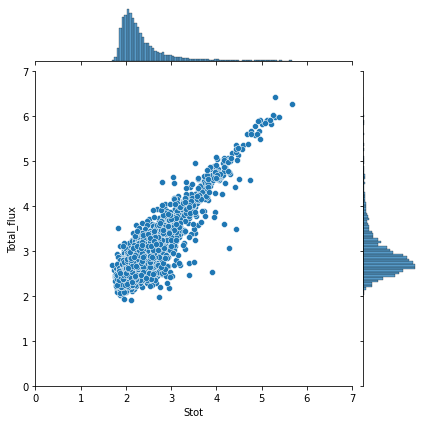

In [4]:
sns.jointplot(data=datalog, x='Stot', y='Total_flux', xlim=[0,7], ylim=[0,7])

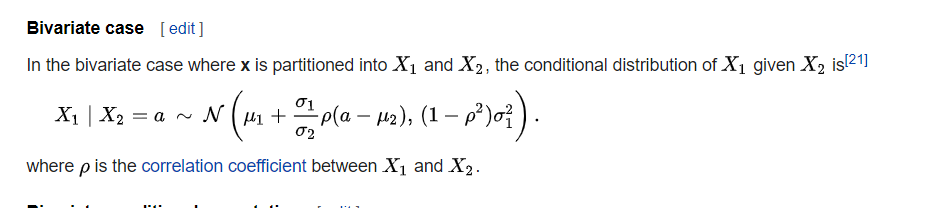

In [5]:
def conditional(mus, cov, a):
    """
    Function to calculate the gaussian of a bivariate normal distribution given the condition that x2==a
    
    returns new mean and new std
    """
    # Definitions
    std1 = cov[0,0]**.5
    std2 = cov[1,1]**.5
    std12 = cov[0,1]
    
    mu1 = mus[0]
    mu2 = mus[1]
    
    # Correlation coefficient
    rho = std12/(std1 * std2)
    
    mu_new = mu1 + std1/std2 * rho * (a - mu2)
    std_new = (1 - rho**2)*std1**2
    
    return mu_new, std_new

Means: [2.15532179 2.75998309]


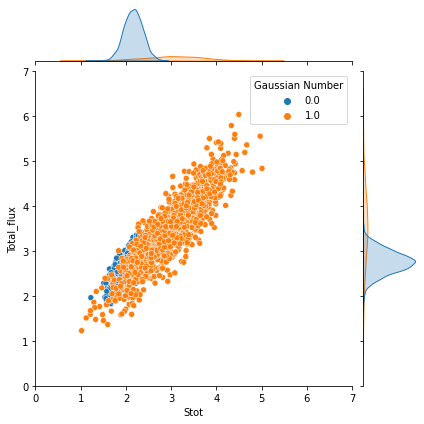

In [9]:
gm_tot = GaussianMixture(n_components=2, random_state=0).fit(datalog[['Stot', 'Total_flux']])
print('Means:', gm_tot.means_[0])

# Sampling the gaussians
sample = gm_tot.sample(5000)
sample_values = sample[0]
sample_gaussian = sample[1]
sample_data = pd.DataFrame(data=np.array([sample_values[:,0], sample_values[:,1], sample_gaussian]).T,
                          columns=['Stot', 'Total_flux', 'Gaussian Number'])


sns.jointplot(data=sample_data, x='Stot', y='Total_flux', hue='Gaussian Number', xlim=[0,7], ylim=[0,7])

## Analysis of number of clusters

### BIC

In [457]:
scores = []
for n in [1,2,3,4,5,6,7,8,9]:
    score_per_n = []
    for i in range(9):
        X = datalog[['Stot', 'Total_flux']]
        gm_tot = GaussianMixture(n_components=n).fit(X)
        
        score = gm_tot.bic(X)
        score_per_n.append(score)
    scores.append(score_per_n)

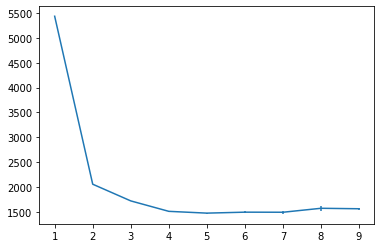

In [458]:
mean_score = np.mean(scores, axis=1)
std = np.std(scores, axis=1)
plt.errorbar([1,2,3,4,5,6,7,8,9], mean_score, yerr=std)
plt.show()

# Lower is better

### silhouette_score

In [459]:
from sklearn.metrics import silhouette_score

scores = []
for n in [2,3,4,5,6,7,8,9]:
    score_per_n = []
    for i in range(20):
        X = datalog[['Stot', 'Total_flux']]
        gm_tot = GaussianMixture(n_components=n).fit(X)

        labels = gm_tot.predict(X)
        score = silhouette_score(X,labels)
        score_per_n.append(score)
    scores.append(score_per_n)

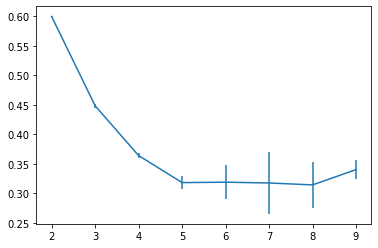

In [460]:
mean_score = np.mean(scores, axis=1)
std = np.std(scores, axis=1)
plt.errorbar([2,3,4,5,6,7,8,9], mean_score, yerr=std)
plt.show()

# Higher is better

### Overlaying fit with data

Text(0, 0.5, 'Total_flux')

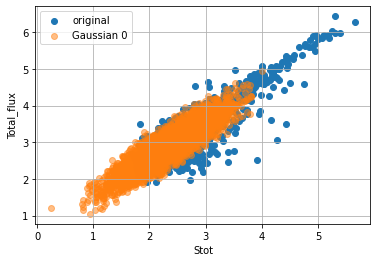

In [7]:
plt.scatter(datalog['Stot'], datalog['Total_flux'], label='original')
for g in np.unique(sample_gaussian):
    filt = sample_gaussian==g
    plt.scatter(sample_values[:,0][filt], sample_values[:,1][filt], alpha=0.5, label=f'Gaussian {g}')
plt.grid()
plt.legend()
plt.xlabel('Stot')
plt.ylabel('Total_flux')

# Generating new data

## Total

In [473]:
newdata = pd.read_csv("../../Data/MIGHTEE/Classification/Combined_secure_postprocessed.csv")

In [474]:
gm_tot.covariances_

array([[[0.24222983, 0.2319561 ],
        [0.2319561 , 0.27649527]]])

In [475]:
cov = gm_tot.covariances_
mus = gm_tot.means_[0]

In [476]:
len(newdata)

5121

In [477]:
tot14 = np.log10(newdata['S_INT14'])

In [478]:
new_mu, new_cov = conditional(mus[::-1], cov.T, tot14)

In [479]:
tot150 = np.random.normal(new_mu, new_cov**.5)

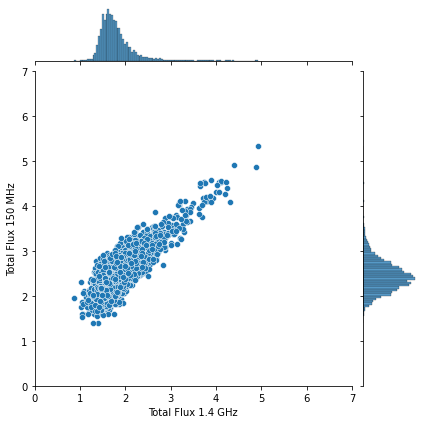

In [480]:
tot_comparison = pd.DataFrame(data=np.array([tot14, tot150]).T, columns=['Total Flux 1.4 GHz', 'Total Flux 150 MHz'])
sns.jointplot(data=tot_comparison, x='Total Flux 1.4 GHz', y='Total Flux 150 MHz', xlim=[0,7], ylim=[0,7])

## Peak

In [481]:
gm_peak = GaussianMixture(n_components=1, random_state=0).fit(datalog[['Speak', 'Peak_flux']])

In [482]:
cov = gm_peak.covariances_
mus = gm_peak.means_[0]

In [483]:
peak14 = np.log10(newdata['S_PEAK14'])

In [484]:
new_mu, new_cov = conditional(mus[::-1], cov.T, peak14)

In [485]:
peak150 = np.random.normal(new_mu, new_cov**.5)

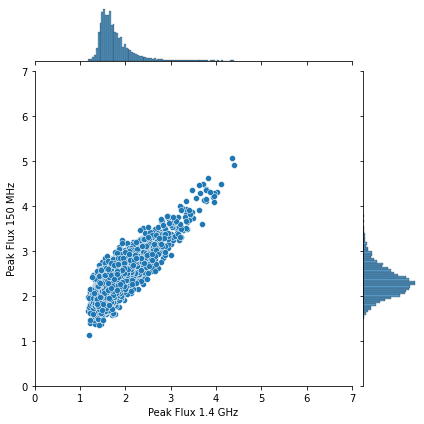

In [486]:
tot_comparison = pd.DataFrame(data=np.array([peak14, peak150]).T, columns=['Peak Flux 1.4 GHz', 'Peak Flux 150 MHz'])
sns.jointplot(data=tot_comparison, x='Peak Flux 1.4 GHz', y='Peak Flux 150 MHz', xlim=[0,7], ylim=[0,7])

## Saving to a file

In [487]:
newdata['Total_flux'] = 10**tot150
newdata['Peak_flux'] = 10**peak150

In [488]:
newdata.to_csv("../../Data/MIGHTEE/Classification/final_gaussian_radio_secure.csv")

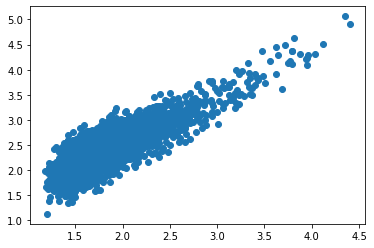

In [489]:
plt.scatter(peak14, peak150)